# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- commentaires tous en anglais
- virer les prints inutiles

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30



# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [6]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([4000, 2000, 1000, 2000, 4000])) #METTRE DANS CONSTANTS.py!!!!
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

In [7]:
#METTRE AILLEURS

def is_inside(point, obstacles):
    for obstacle in range(len(obstacles)):
        min_x = min(s[0] for s in obstacles[obstacle])
        max_x = max(s[0] for s in obstacles[obstacle])
        min_y = min(s[1] for s in obstacles[obstacle])
        max_y = max(s[1] for s in obstacles[obstacle])
        for summit in range(len(obstacles[obstacle])):
            if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                return True
    return False

### Step 1: Check the connexion between the Thymio and the computer

In [8]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False


### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(550, 1080), (869, 1080), (869, 604), (550, 604)], [(1063, 1080), (1369, 1080), (1369, 614), (1063, 614)]]
Centroid de la goal area : [1630.5  571.5]
Vecteur direction du robot : 97 -3
Centroid du robot : [512 511]


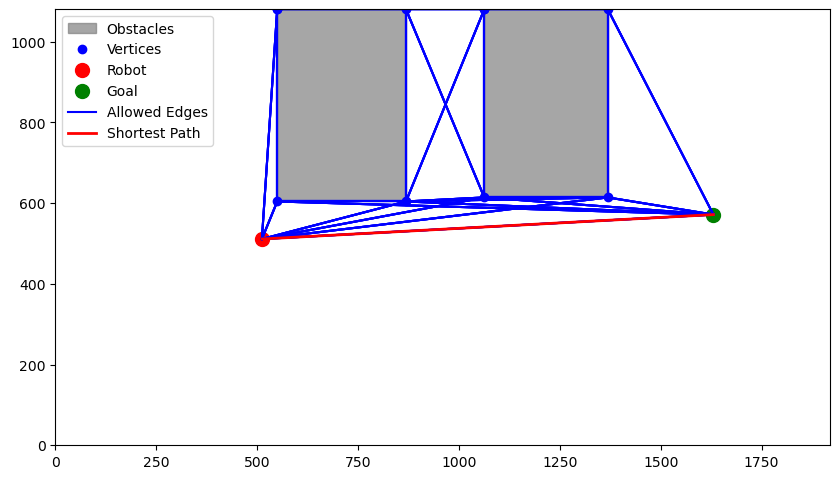

In [12]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

1 rotation
Kalman:  27.00000000000142 26.99999999999998 -0.03091797956256005 2.3100023100023095 1.9250019250019248
[-0.03091798] [0.04914073] [0.08005871]
[(88, 30)]
2 translation
Kalman:  28.462515032638827 27.018271434049232 -0.023998026617595793 0.4619992763735188 -0.6160022459651571
trabslation: [(88, 30)]
Error: [59.61210298]
3 translation
Kalman:  28.387590431833555 27.010298644636105 -0.0003576160829975349 1.1676934925663383 0.7276933094232199
trabslation: [(88, 30)]
Error: [59.68733273]
4 translation
Kalman:  28.85107883141871 27.00881124785474 0.007416208100464506 1.5929798242980548 1.4757006086452127
trabslation: [(88, 30)]
Error: [59.22450579]
5 translation
Kalman:  29.525482653826007 27.013589792268718 0.010045230859757942 1.8321509784650551 1.7618561153208911
trabslation: [(88, 30)]
Error: [58.55072864]
6 translation
Kalman:  30.2750634351281 27.021813716885003 0.009972784918294751 1.8725395561311784 1.9221695714647085
trabslation: [(88, 30)]
Error: [57.80171187]
7 transla

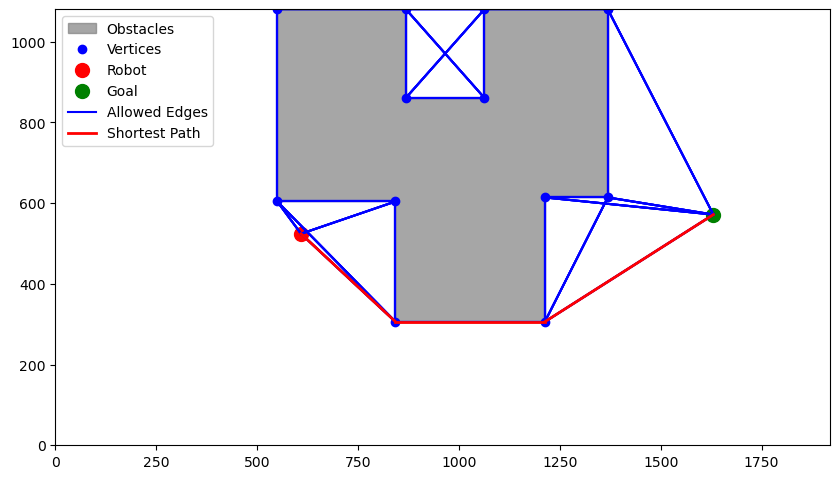

glob nav path : [(609.0, 524.0), (843.0, 306.0), (1213.0, 306.0), (1630.5, 571.5)]
camera measurements:  (32, 28) -0.23949926591015905
centroid camera:  (32, 28)
camera fin: [(45, 16), (65, 16), (88, 30)]
27 rotation
Kalman:  31.99999967958047 27.999989631099783 -0.23932889212161318 -1.4583690677267036 -1.3379688563887278
[-0.23932889] [-0.74541903] [-0.50609014]
[(45, 16), (65, 16), (88, 30)]
28 rotation
Kalman:  31.49946052271687 28.122096510589188 -0.2515626342309322 -1.4692610032978546 -0.5505359564545559
[-0.25156263] [-0.73165211] [-0.48008948]
[(45, 16), (65, 16), (88, 30)]
29 rotation
Kalman:  31.215601678868477 28.193082256453394 -0.2993139372401304 -1.6135801031820602 0.6721475639247158
[-0.29931394] [-0.72421709] [-0.42490316]
[(45, 16), (65, 16), (88, 30)]
30 rotation
Kalman:  31.091827784291002 28.231383766333913 -0.3758753931869703 -1.6360077684278425 1.2084302755821872
[-0.37587539] [-0.72133838] [-0.34546299]
[(45, 16), (65, 16), (88, 30)]
31 rotation
Kalman:  31.033960

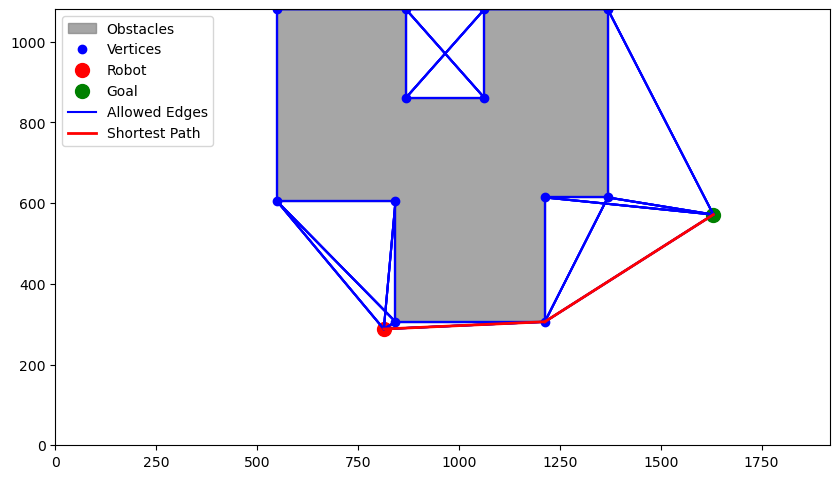

glob nav path : [(814.0, 288.0), (1213.0, 306.0), (1630.5, 571.5)]
camera measurements:  (44, 15) -0.8171335369259062
centroid camera:  (44, 15)
camera fin: [(65, 16), (88, 30)]
60 rotation
Kalman:  44.00028973861738 14.999847622785133 -0.816120217766272 1.3589420118837054 1.7428127102556705
[-0.81612022] [0.047591] [0.86371122]
[(65, 16), (88, 30)]
61 rotation
Kalman:  44.35386247846192 14.623646119772236 -0.81282440360849 1.259494000580665 0.21822346963394312
[-0.8128244] [0.0665655] [0.8793899]
[(65, 16), (88, 30)]
62 rotation
Kalman:  44.50231118324083 14.464618101034578 -0.7625127130542327 1.5332034081172998 -0.8313148146082094
[-0.76251271] [0.0747655] [0.83727821]
[(65, 16), (88, 30)]
63 rotation
Kalman:  44.56836939081263 14.401850753191033 -0.6845307641780963 1.571322941066181 -1.3031063840950252
[-0.68453076] [0.07806043] [0.76259119]
[(65, 16), (88, 30)]
64 rotation
Kalman:  44.59821065579088 14.378046761485814 -0.597356255023681 1.58595366326732 -1.4495069470089998
[-0.5973

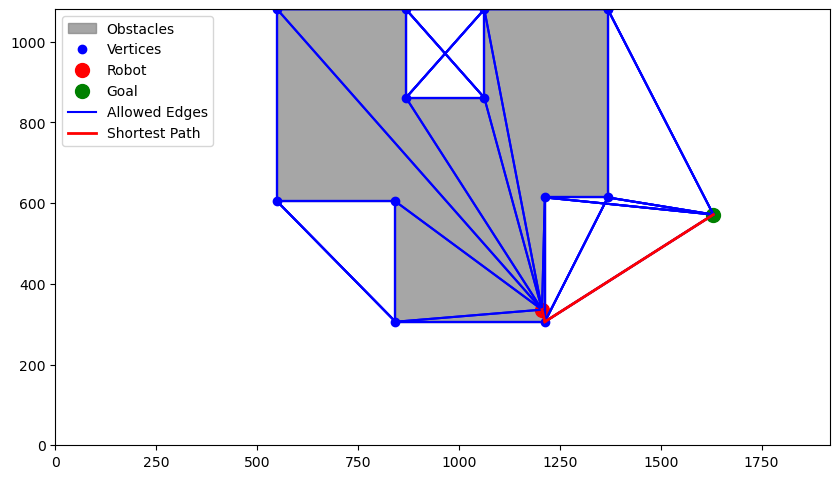

glob nav path : [(1206.0, 336.0), (1213.0, 306.0), (1630.5, 571.5)]
camera measurements:  (65, 18) 0.058755822715722696
centroid camera:  (65, 18)
camera fin: [(65, 16), (88, 30)]
101 rotation
Kalman:  65.00030416738997 18.00009718934112 0.059516702273710254 1.4170717362341037 1.7482230250808741
[0.0595167] [-1.5709484] [-1.63046511]
[(65, 16), (88, 30)]
102 rotation
Kalman:  65.55221880692862 18.03302008795437 0.045904197671402094 0.5875604673209927 1.2825702482167043
[0.0459042] [-1.836022] [-1.8819262]
[(65, 16), (88, 30)]
103 rotation
Kalman:  65.78771613951719 18.045850163247756 0.0005057445496763624 -0.9272009010151951 1.4400034248806755
[0.00050574] [-1.93833234] [-1.93883808]
[(65, 16), (88, 30)]
104 rotation
Kalman:  65.85029001697241 18.045747624742248 -0.07695609566352563 -1.3397598864844045 1.5017328958203442
[-0.0769561] [-1.96471045] [-1.88775435]
[(65, 16), (88, 30)]
105 rotation
Kalman:  65.8666083472007 18.04404282507317 -0.16348847245273715 -1.4974988502963946 1.52538

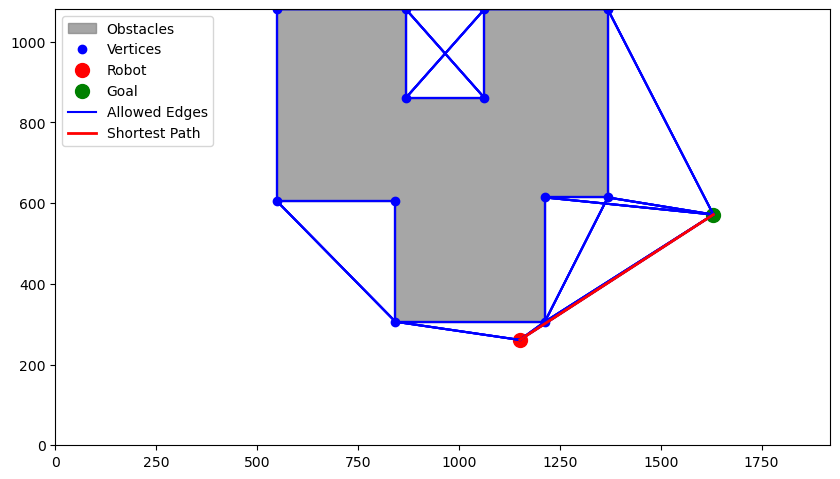

glob nav path : [(1151.0, 261.0), (1630.5, 571.5)]
camera measurements:  (62, 14) -1.8417431771333173
centroid camera:  (62, 14)
camera fin: [(88, 30)]
130 rotation
Kalman:  62.000134456999085 13.999756569794775 -1.8410334124744059 1.711948405344073 1.849133336083808
[-1.84103341] [0.55166408] [2.39269749]
[(88, 30)]
131 rotation
Kalman:  61.84091145551625 13.425425400393326 -1.8317775847130706 1.4070944856922776 0.26510148590656035
[-1.83177758] [0.5647645] [2.39654208]
[(88, 30)]
132 rotation
Kalman:  61.787501886037376 13.232112439451663 -1.7757727697857586 1.4889892383221377 -1.1519678727384193
[-1.77577277] [0.56909364] [2.34486641]
[(88, 30)]
133 rotation
Kalman:  61.77611241779483 13.177508627540629 -1.69313256247285 1.5884614446323566 -1.3576992605265494
[-1.69313256] [0.57037302] [2.26350558]
[(88, 30)]
134 rotation
Kalman:  61.78200937463742 13.205431448063289 -1.5968563088686174 1.558512982931605 -1.9462158712366087
[-1.59685631] [0.56972044] [2.16657675]
[(88, 30)]
135 rota

179 translation
Kalman:  74.53295132228119 23.05222460697655 0.657500862506761 2.0017016894900697 2.0272965925714357
trabslation: [(88, 30)]
Error: [15.15364586]
180 translation
Kalman:  75.17619230894992 23.547812284185905 0.6584233586672374 2.0392784115123352 1.9725729506214649
trabslation: [(88, 30)]
Error: [14.35551358]
181 translation
Kalman:  75.82121006033398 24.048138668763922 0.6582461958838718 2.002643537760868 2.0536461797500745
trabslation: [(88, 30)]
Error: [13.55535236]
182 translation
Kalman:  76.46289280853148 24.54516534721555 0.6554744479935866 1.937662387263698 2.059119419928512
trabslation: [(88, 30)]
Error: [12.76166382]
183 translation
Kalman:  77.1059927514632 25.03877619068357 0.6532739482327362 1.9893236565079275 2.0357160649278425
trabslation: [(88, 30)]
Error: [11.97051108]
184 translation
Kalman:  77.75786330617666 25.537390758436427 0.6524332661000984 2.0345504287109812 2.0522707328529393
trabslation: [(88, 30)]
Error: [11.17211911]
185 translation
Kalman: 

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 71 19
Centroid du robot : [1706  412]


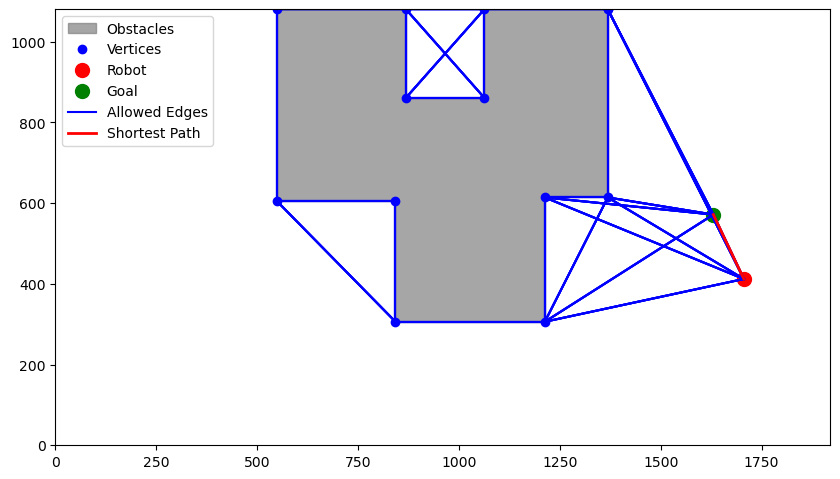

glob nav path : [(1706.0, 412.0), (1630.5, 571.5)]
camera measurements:  (92, 22) 0.26147881571224924
centroid camera:  (92, 22)
camera fin: [(88, 30)]
200 rotation
Kalman:  92.00020223966669 22.00021669433129 0.26262023297708126 0.8683239982281121 1.687898798576562
[0.26262023] [2.03447499] [1.77185476]
[(88, 30)]
201 rotation
Kalman:  92.40935212412802 22.11010893618416 0.25726186380013866 1.0673222474525987 0.0038073462418750648
[0.25726186] [2.08041712] [1.82315525]
[(88, 30)]
202 rotation
Kalman:  92.55933688481443 22.148375581151488 0.30696192332601 1.3917953949846829 -0.9131413398373477
[0.30696192] [2.0968941] [1.78993217]
[(88, 30)]
203 rotation
Kalman:  92.61851703751736 22.167227095845618 0.3837029380795559 1.5172846902638808 -1.3343435647636555
[0.38370294] [2.10356343] [1.71986049]
[(88, 30)]
204 rotation
Kalman:  92.64380039736068 22.17767998457717 0.4704509810695966 1.565311343976071 -1.4614378490212938
[0.47045098] [2.1065412] [1.63609022]
[(88, 30)]
205 rotation
Kalman

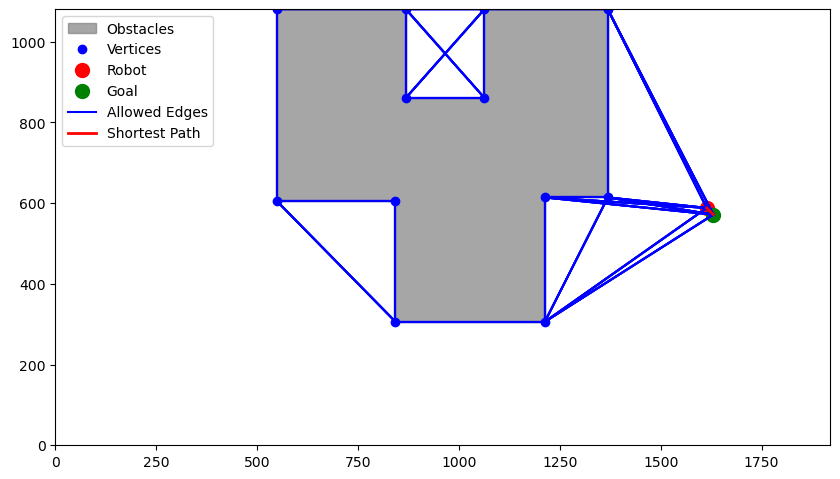

glob nav path : [(1614.0, 588.0), (1630.5, 571.5)]
camera measurements:  (87, 31) 1.9956284897142391
centroid camera:  (87, 31)
camera fin: []
236 rotation
je suis au goal


In [13]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = 'rotation'

speed_correction = 14 #calibration cst for rotation counterclockwise

intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])

robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)



old_time = 0.0
printkal = True
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("je suis au goal")
        break
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # test if local (with proximity)
    if(detected):
        await stop_robot()
        global_state = 'local_avoidance'

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()

    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        print(intermediate_goals)
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise
            speed_correction = 1.0 
        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise
            speed_correction = 1.0 

    elif global_state == 'translation':
        
        print("trabslation:", intermediate_goals)
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            print("je m'arrete")
            await stop_robot()
            global_state = 'camera'
            continue
            
        
        
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        P_control_translation = 0 / (math.pi / 4.0)
        robot_speed = [50 + int(P_control_translation*angle), 50 - int(P_control_translation*angle)]
        speed_correction = 0.75

        
        if abs(angle) > math.pi / 2.0:
            await stop_robot()
            global_state = 'camera'
            continue
        
        
    elif global_state == 'camera':
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = 'rotation'
        continue
        
        
        
    elif global_state == 'local_avoidance':
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        print("OBject:", Object)
        print("avant append:", obstacles)
        obstacles.append(Object)
        print("après append:", obstacles)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-50, -50)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
            await client.sleep(0.4)
        
        global_state = "camera"
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [11]:
await stop_robot()